# Acoustic Rocket Dataset Tutorial: Loading, Filtering, Plotting, and Saving ASTRA Data

This tutorial goes over the basics of how to read, filter, and plot data from Aggregated Smartphone Timeseries of Rocket-generated Acoustics (ASTRA), an open-access dataset.

A PKL file containing a single recording from ASTRA is included with this tutorial. The full ASTRA dataset can be downloaded from __[Harvard Dataverse](https://doi.org/10.7910/DVN/ZKIS2K)__ or __[Google Drive](https://drive.google.com/drive/folders/1QKHUzdT0et6xpKXm8LFOmHJ9_gx0J2ib?usp=sharing)__ (contact Sarah Popenhagen at spopen@hawaii.edu for access to Google Drive folder).

For details on the dataset and the software used to collect and store the data, see __[Popenhagen and Garces (2025)](https://doi.org/10.3390/signals6010005)__ and __[Garces, et al. (2020)](https://doi.org/10.3390/signals3020014)__, respectively.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
# from quantum_inferno.plot_templates.plot_templates_examples import plot_wf_mesh_vert_example
# from quantum_inferno.cwt_atoms import cwt_chirp_from_sig

## Section 1: Loading the Dataset

In the following cell, we'll define the path to the dataset. By default, this path will point to the single-recording subset of ASTRA included with this tutorial. After you've completed the tutorial with this file, feel free to download the full ASTRA dataset and use the last line of the cell to change the 'PATH_TO_PKL' variable to point to its location on your device.

In [4]:
TUTORIAL_PICKLE_FILE_NAME = "ASTRA_ART-1_1637620009.pkl"
CURRENT_DIRECTORY = os.getcwd()
PATH_TO_TUTORIAL_PKL = os.path.join(CURRENT_DIRECTORY, TUTORIAL_PICKLE_FILE_NAME)
PATH_TO_PKL = PATH_TO_TUTORIAL_PKL
# PATH_TO_PKL = "<insert path to ASTRA.pkl on your device here>"

Once we have the location of the file, we can read the data using the pandas module.

In [5]:
astra_ds = pd.read_pickle(PATH_TO_PKL)
astra_ds.head()

,audio_wf_raw,first_sample_epoch_s,audio_sample_rate_nominal_hz,station_id,station_make,station_model_number,station_latitude,station_longitude,launch_id,rocket_type,rocket_model_number,n_solid_rocket_boosters,launch_pad_latitude,launch_pad_longitude,estimated_propagation_distance_km,reported_launch_epoch_s,start_aligned_arrival_time_estimate_epoch_s,peak_aligned_arrival_time_estimate_epoch_s
436,"[-3.7476486340892734e-06, -3.3908352179423673e...",1.668581e+09,800.0,1637620009,samsung,SM-G981U1,28.419188,-80.701593,ART-1,NASA Space Launch System,SLS-B1,2,28.627222,-80.620833,24.373453,1.668581e+09,1.668581e+09,1.668581e+09


Each row of the pandas DataFrame contains all data and metadata from a single recording in ASTRA, with individual columns for each of the available fields.

To keep track of all the column names, we'll define the 'ASTRALabels' class, and then initiate an instance of it in the next cell.

In [7]:
class ASTRALabels:
    """
    A class containing the column names used in ASTRA.
    """
    def __init__(
            self,
            station_id: str = "station_id",
            station_make: str = "station_make",
            station_model: str = "station_model_number",
            audio_data: str = "audio_wf_raw",
            first_sample_epoch_s: str = "first_sample_epoch_s",
            audio_fs: str = "audio_sample_rate_nominal_hz",
            station_lat: str = "station_latitude",
            station_lon: str = "station_longitude",
            launch_id: str = "launch_id",
            launch_pad_lat: str = "launch_pad_latitude",
            launch_pad_lon: str = "launch_pad_longitude",
            reported_launch_epoch_s: str = "reported_launch_epoch_s",
            s_aligned_toa_est: str = "start_aligned_arrival_time_estimate_epoch_s",
            p_aligned_toa_est: str = "peak_aligned_arrival_time_estimate_epoch_s",
            est_prop_dist_km: str = "estimated_propagation_distance_km",
            rocket_type: str = "rocket_type",
            rocket_model_number: str = "rocket_model_number",
            n_srbs: str = "n_solid_rocket_boosters",
    ):
        """
        Defaults should be left in place for most uses.
        :param station_id: column containing the recording smartphones' unique station ID numbers
        :param station_make: column containing the recording smartphones' makes
        :param station_model: column containing the recording smartphones' models
        :param audio_data: column containing the raw, uncalibrated audio data
        :param first_sample_epoch_s: column containing the epoch second of the first sample
        :param audio_fs: column containing the sample rate of the audio data in Hertz
        :param station_lat: column containing the recording smartphones' latitude in degrees
        :param station_lon: column containing the recording smartphones' longitude in degrees
        :param launch_id: column containing the launches' unique ID strings
        :param launch_pad_lat: column containing the launch pad latitudes in degrees
        :param launch_pad_lon: column containing the launch pad longitudes in degrees
        :param reported_launch_epoch_s: column containing the reported launch times in epoch seconds
        :param s_aligned_toa_est: column containing the start-aligned arrival time estimates in epoch seconds
        :param p_aligned_toa_est: column containing the peak-aligned arrival time estimates in epoch seconds
        :param est_prop_dist_km: column containing the estimated propagation distances in kilometers
        :param rocket_type: column containing the type of rockets launched (ex: "SpaceX Falcon 9")
        :param rocket_model_number: column containing the model number of the rockets launched (ex: "F9-B5")
        :param n_srbs: column containing the number of solid rocket boosters used
        """
        self.station_id = station_id
        self.station_make = station_make
        self.station_model = station_model
        self.audio_data = audio_data
        self.audio_fs = audio_fs
        self.station_lat = station_lat
        self.station_lon = station_lon
        self.launch_id = launch_id
        self.launch_pad_lat = launch_pad_lat
        self.launch_pad_lon = launch_pad_lon
        self.reported_launch_epoch_s = reported_launch_epoch_s
        self.first_sample_epoch_s = first_sample_epoch_s
        self.s_aligned_toa_est = s_aligned_toa_est
        self.p_aligned_toa_est = p_aligned_toa_est
        self.est_prop_dist_km = est_prop_dist_km
        self.rocket_type = rocket_type
        self.rocket_model_number = rocket_model_number
        self.n_srbs = n_srbs

In [8]:
ds_labels = ASTRALabels()

With the labels now easily accessible, we'll print out some metadata about the recording(s) in our dataset. Notice how the desired field (in this case: 'launch_id') is accessed using the column names stored in 'ds_labels'.

In [9]:
launch_ids, launch_counts = np.unique(astra_ds[ds_labels.launch_id], return_counts=True)
n_signals = len(astra_ds)
n_events = len(launch_ids)
print(f"This dataset contains {n_signals} recording(s) from {n_events} unique launch event(s).")

This dataset contains 1 recording(s) from 1 unique launch event(s).


We can also loop through each launch event in the dataset and print out the metadata associated with individual launches.

In [11]:
print(f"All launches in PKL file loaded from: {PATH_TO_PKL}")
for launch_id, count in zip(launch_ids, launch_counts):
    launch_df = astra_ds[astra_ds[ds_labels.launch_id] == launch_id]
    rocket_type = launch_df[ds_labels.rocket_type][launch_df.index[0]]
    launch_date = launch_df[ds_labels.reported_launch_epoch_s][launch_df.index[0]]
    date_string = (datetime.fromtimestamp(launch_date, tz=timezone.utc)).strftime("%d %b %Y")
    print(f"\t{rocket_type} launch {launch_id} on {date_string}: {count} recording(s)")

All launches in PKL file loaded from: /home/fc7b9129-e678-4448-835a-cf0cd275f50d/ASTRA_ART-1_1637620009.pkl
	NASA Space Launch System launch ART-1 on 16 Nov 2022: 1 recording(s)


## Section 2: Filtering the Dataset

The dataset can be filtered easily using any of the included fields. For example, you could select a subset containing only data recorded from SpaceX Falcon 9 rockets using this line of code:

```python
falcon9_df = astra_ds[astra_ds[ds_labels.rocket_model_number] == "F9-B5"]]
```

For this tutorial, we'll select a subset of the dataset containing only the data from a single event: NASA's Artemis I launch from November 2022. Each launch event has a unique launch ID string. This launch ID is usually the official flight number of the launch, but some launches don't have compact flight numbers, in which case the launch ID is an abbreviation of the launch's name. For Artemis I, the launch ID is "ART-1". By selecting only those rows with "ART-1" in their launch ID field, we create a subset of the dataset containing all available data from our chosen event and no data from any other events in the file.

In [12]:
artemis_launch_id: str = "ART-1"
artemis_launch_df = astra_ds[astra_ds[ds_labels.launch_id] == artemis_launch_id]

## Section 3: Plotting ASTRA Data

To plot ASTRA audio data, the time array must be reconstructed from the sample rate and epoch time of the first sample. This can be performed easily using numpy. In the following cell, we'll define a function to plot all available data from a single event. Read through the comments in the function for a detailed explanation of each step.

In [15]:
# a colorblind-friendly color cycle to use in our plots
CBF_COLOR_CYCLE = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']


def single_event_example_plots(launch_df, ds_labels, plot_tfrs=True):
    launch_id = launch_df[ds_labels.launch_id][launch_df.index[0]]
    # We'll be plotting the waveforms from the launch relative to the mission's reported launch time.
    rep_launch_epoch_s = launch_df[ds_labels.reported_launch_epoch_s][launch_df.index[0]]
    date_string = (datetime.fromtimestamp(rep_launch_epoch_s, tz=timezone.utc)).strftime("%d %B %Y")
    xlabel = f"Time (s) since launch"
    # For the title, we'll include some information on the launch included in the ASTRA dataset
    launch_n_srbs = launch_df[ds_labels.n_srbs][launch_df.index[0]]
    launch_rocket_type = launch_df[ds_labels.rocket_type][launch_df.index[0]]
    launch_rocket_model = launch_df[ds_labels.rocket_model_number][launch_df.index[0]]
    title = f"Normalized ASTRA audio data from launch {launch_id} on {date_string}"
    title += f"\nRocket: {launch_rocket_type}, {launch_rocket_model} configuration ({launch_n_srbs} SRBs)"
    # We'll also set some parameters for the figure
    fig, ax = plt.subplots(figsize=(10, 7))
    y_adj = 0
    y_adj_buff = 2.2
    t_max = 0
    ticks, tick_labels = [], []
    waveform_color, sa_toa_color, pa_toa_color = "k", CBF_COLOR_CYCLE[0], CBF_COLOR_CYCLE[1]
    # And sort the data by the estimated propagation distance
    launch_df = launch_df.sort_values(by=ds_labels.est_prop_dist_km)
    for station in launch_df.index:
        # We'll start by normalizing the audio data from each station
        audio_data = launch_df[ds_labels.audio_data][station]
        audio_data_abs_max = np.nanmax(np.abs(launch_df[ds_labels.audio_data][station]))
        audio_data = audio_data / audio_data_abs_max
        # The epoch time of the first sample of each recording is included in ASTRA
        start_time = launch_df[ds_labels.first_sample_epoch_s][station]
        # The sample rate of all the audio data in ASTRA is 800 Hz, but it is also included for convenience
        fs = launch_df[ds_labels.audio_fs][station]
        # With the sample rate, start time, and length of the audio data array, we can reconstruct the time array
        epoch_time = (np.array(range(len(audio_data))) / fs) + start_time
        # Epoch times are useful, but not very readable on a plot, so we'll convert the array to time since the launch
        relative_time = epoch_time - rep_launch_epoch_s
        # To speed up plot generation, we'll trim the signal to start at the reported launch time
        first_idx = np.argwhere(relative_time >= 0).flatten()[0]
        relative_time = relative_time[first_idx:]
        audio_data = audio_data[first_idx:]
        # We'll also keep track of the maximum time in the recording to set the x-axis limits later
        t_max = max(t_max, relative_time[-1])
        # The estimated propagation distance in kilometers is also included with each recording in ASTRA, along with the
        # ground truth latitudes and longitudes of the launch pad and the station
        est_prop_distance_km = launch_df[ds_labels.est_prop_dist_km][station]
        # We'll plot the normalized audio data from each station in order of their estimated propagation distances, with
        # the y-axis adjusted for each station
        ax.plot(relative_time, audio_data + y_adj, lw=1, color=waveform_color)
        ticks.append(y_adj)
        tick_labels.append(f"{round(est_prop_distance_km, 1)} km")
        # We'll also plot the estimated arrival times of the start and peak of the rocket launch signal as blue and
        # green lines, respectively. For detailed explanations of how these estimates were made, Popenhagen &
        # Garces, 2025 (link at the top of this file).
        relative_start_toa_estimate = launch_df[ds_labels.s_aligned_toa_est][station] - rep_launch_epoch_s
        relative_peak_toa_estimate = launch_df[ds_labels.p_aligned_toa_est][station] - rep_launch_epoch_s
        # We'll add labels to the first station's TOA estimate markers for clarity
        marker_lines_ylim = (y_adj - y_adj_buff / 2, y_adj + y_adj_buff / 2)
        marker_lines_zorder = 10
        if station == launch_df.index[0]:
            ax.vlines(
                ymin=marker_lines_ylim[0],
                ymax=marker_lines_ylim[1],
                x=relative_start_toa_estimate,
                color=sa_toa_color,
                zorder=marker_lines_zorder,
                label="Start-aligned TOA estimate",
                ls="-",
                lw=2,
            )
            ax.vlines(
                ymin=marker_lines_ylim[0],
                ymax=marker_lines_ylim[1],
                x=relative_peak_toa_estimate,
                color=pa_toa_color,
                zorder=marker_lines_zorder,
                label="Peak-aligned TOA estimate",
                ls="--",
                lw=2,
            )
        else:
            ax.vlines(
                ymin=marker_lines_ylim[0],
                ymax=marker_lines_ylim[1],
                x=[relative_start_toa_estimate, relative_peak_toa_estimate],
                color=[sa_toa_color, pa_toa_color],
                zorder=marker_lines_zorder,
                ls=["-", "--"],
                lw=2,
            )
        y_adj -= y_adj_buff
        # For each station, we can also plot the continuous wavelet transform (CWT) of the audio data using functions in
        # the quantum_inferno module
        if not plot_tfrs:
            continue
        tfr_title = f"CWT and waveform from launch {launch_id}"
        cwt, cwt_bits, time_s, frequency_cwt_hz = cwt_chirp_from_sig(
            sig_wf=audio_data,
            frequency_sample_rate_hz=fs,
            band_order_nth=3
        )
        _ = plot_wf_mesh_vert_example(
            station_id=f"{launch_df[ds_labels.station_id][station]} ({est_prop_distance_km:.1f} km)",
            wf_panel_a_sig=audio_data,
            wf_panel_a_time=relative_time,
            mesh_time=time_s,
            mesh_frequency=frequency_cwt_hz,
            mesh_panel_b_tfr=cwt_bits,
            figure_title=tfr_title,
        )
    # We'll add some finishing touches to the waveform plot settings
    fontsize = 12
    ax.set(xlabel=xlabel, xlim=(0, t_max), ylim=(min(ticks) - 1.1 * y_adj_buff / 2, max(ticks) + 1.1 * y_adj_buff / 2))
    ax.set_title(title, fontsize=fontsize + 2)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.yaxis.set_ticks(ticks)
    ax.yaxis.set_ticklabels(tick_labels)
    ax.tick_params(axis="y", labelsize="large")
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True, labelsize="large")
    ax.legend(frameon=False, bbox_to_anchor=(.99, .99), loc='upper right', fontsize=fontsize)
    plt.subplots_adjust()

To generate the time domain plots for our example event, we'll call our plotting function with plot_tfrs=False.

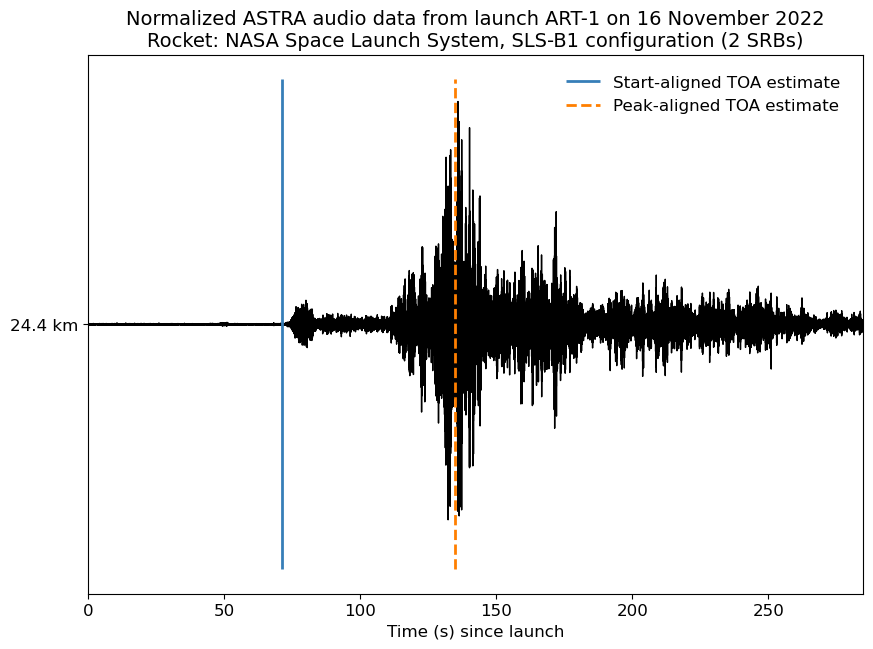

In [16]:
single_event_example_plots(launch_df=artemis_launch_df, ds_labels=ds_labels, plot_tfrs=False)

If we want to generate the time frequency representations, we can call the same plotting function but with plot_tfrs=True.

In [ ]:
single_event_example_plots(launch_df=artemis_launch_df, ds_labels=ds_labels, plot_tfrs=True)

We can also loop through all the events and generate plots for each if we would like.

Plotting all available ASTRA audio data from: ART-1
Done.


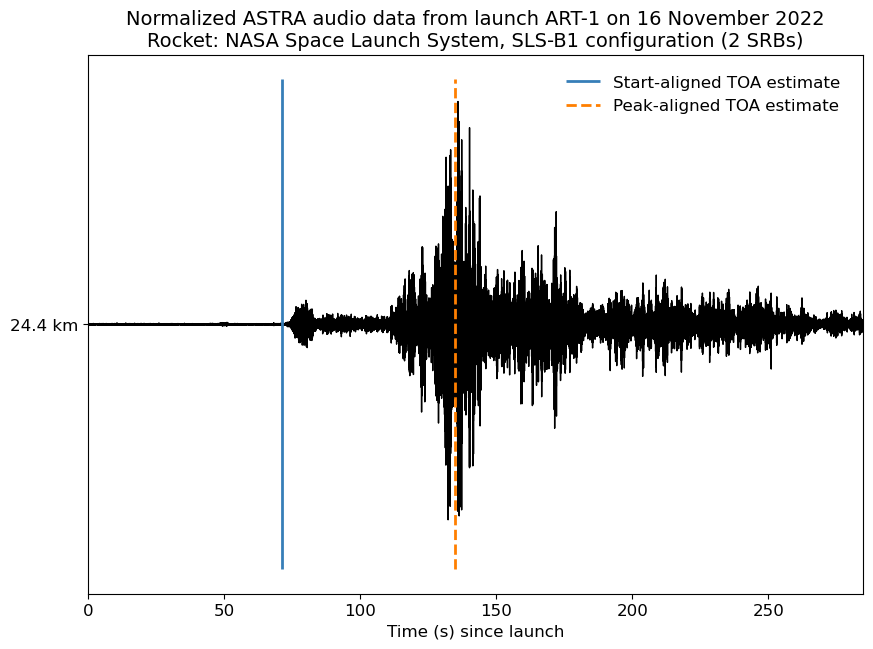

In [17]:
for launch_id in launch_ids:
    print(f"Plotting all available ASTRA audio data from: {launch_id}")
    launch_df = astra_ds[astra_ds[ds_labels.launch_id] == launch_id]
    single_event_example_plots(launch_df, ds_labels, plot_tfrs=False)
print("Done.")

## Section 4: Saving ASTRA Data

We can also save a subset of the data to a new pickle file. This can be useful in some cases as the full dataset is quite large and may not be needed for all applications. We can save any subset (data recorded at ranges < 30 km, data from only one type of rocket, etc.), but we'll stick with our example subset of data from a single event. For this example, we'll save PKL files of Artemis I data, but this can be modified by simply changing the 'launch_id_to_save' variable.

In [22]:
launch_id_to_save = "ART-1"
# Check if the launch id is in the dataset
if launch_id_to_save in launch_ids:
    subset_to_save = astra_ds[astra_ds[ds_labels.launch_id] == launch_id_to_save]
    # Print some details about the subset
    n_signals = len(subset_to_save)
    rocket_type = subset_to_save[ds_labels.rocket_type][subset_to_save.index[0]]
    launch_date = subset_to_save[ds_labels.reported_launch_epoch_s][subset_to_save.index[0]]
    date_string = (datetime.fromtimestamp(launch_date, tz=timezone.utc)).strftime("%d %b %Y")
    print(f"Selected event: {rocket_type} launch {launch_id_to_save} on {date_string}: {n_signals} recording(s)")
    
    # Save the subset DataFrame to a new pickle file
    output_filename = f"ASTRA_{launch_id_to_save}_{n_signals}.pkl"
    output_path = os.path.join(CURRENT_DIRECTORY, output_filename)
    print(f"Saving subset of ASTRA containing all available data from launch {launch_id_to_save} to: {output_path}")
    subset_to_save.to_pickle(output_path)
else:
    print("Requested data not found. No file saved.")

Selected event: NASA Space Launch System launch ART-1 on 16 Nov 2022: 1 recording(s)
Saving subset of ASTRA containing all available data from launch ART-1 to: /home/fc7b9129-e678-4448-835a-cf0cd275f50d/ASTRA_ART-1_1.pkl


We can also save data from a single recording of an event by filtering by station ID as well as launch ID. We'll take a look at the available stations for our selected event and then choose one to save.

In [24]:
subset_to_save = astra_ds[astra_ds[ds_labels.launch_id] == launch_id_to_save]
print("Available signals from the selected launch:")
for station in subset_to_save.index:
    station_id = subset_to_save[ds_labels.station_id][station]
    dist_km = subset_to_save[ds_labels.est_prop_dist_km][station]
    print(f"\tStation ID: {station_id} ({dist_km:.1f} km from launch pad)")

Available signals from the selected launch:
	Station ID: 1637620009 (24.4 km from launch pad)


In [26]:
station_id_to_save: str = "1637620009"
# Check if the station ID is in the subset DataFrame
if station_id_to_save in subset_to_save[ds_labels.station_id].values:
    output_filename = f"ASTRA_{launch_id_to_save}_{station_id_to_save}.pkl"
    subset_to_save = subset_to_save[subset_to_save[ds_labels.station_id] == station_id_to_save]
    output_path = os.path.join(CURRENT_DIRECTORY, output_filename)
    print(f"Saving the station {station_id_to_save} data from launch {launch_id_to_save} to: {output_path}")
    subset_to_save.to_pickle(output_path)
else:
    print(f"Station ID '{answer}' not found in the selected launch subset. No data saved.")

Saving the station 1637620009 data from launch ART-1 to: /home/fc7b9129-e678-4448-835a-cf0cd275f50d/ASTRA_ART-1_1637620009.pkl


This concludes the tutorial. For more details on ASTRA, see the references listed at the beginning of the tutorial. If you have any questions, 